# This python code shows a smart way of calculating the 2D correlation function using the fast Fourier transform and appealing to a the 

In [1]:
#Importing all necessary packages

from __future__ import division


import pims


import pandas as pd

from math import *

from scipy.signal import correlate

import numpy as np

import statsmodels.api as sm

from scipy.ndimage import imread

from scipy.misc import *

import matplotlib.pyplot as plt

from scipy import fft
from scipy import interpolate
from spectrum.window import window_tukey
#import warnings
#warnings.simplefilter('ignore',np.RankWarning)

%pylab inline





Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
images=pims.ImageSequence( '/home/raphael/Documents/python/Colliods/Correlations/Sckit_Image/RUN7_3/GrowthRun7_3BigImages/*.tif'  ,as_grey=True)
images=pims.ImageSequence('/home/raphael/Documents/python/Colliods/Correlations/Sckit_Image/Test' ,as_grey=True) 


len(images)

/usr/local/lib/python3.4/dist-packages/pims/image_sequence.py:104: UserWarning: Loading ALL files in this directory. To ignore extraneous files, use a pattern like 'path/to/images/*.png'
  UserWarning)


2

In [3]:
#Takes averages of all images
def average(image):
    imagess = [im - np.average(im) for im in image]
    #return np.array(image),np.array(image).shape
    return imagess

In [4]:
#This does the correlation. It is much faster doing it in FFT space.
 

def Corr_2D(x):
    length=len(x) 
    l = 2 ** int(np.log2(length * 2 - 1))
    fftx = np.fft.fft2(x)
    fftabs = fftx * np.conjugate(fftx)
    ret = np.fft.ifft2(fftabs)
    ret = np.fft.ifftshift(ret)
    return (ret)/np.max(ret), np.fft.ifftshift(fftx)




In [5]:
#Implementing Tureky window

def Tukey_Window(image):
    x,y=image.shape
    
    x_tukey=window_tukey(x, r=1).tolist()
    x_arr = np.array([x_tukey]*y)
    
    y_tukey=window_tukey(y, r=1).tolist()
    y_arr = np.array([y_tukey]*x)
    window = (x_arr*y_arr.T).T
    #imshow(x_arr*y_arr.T)
    #window.shape == image[0].shape
    return window  

In [6]:
#windowing the image

def windowed_image(image):
    windowed=Tukey_Window(image)*image
    return windowed    




In [7]:
#Padding windowed image

def windowed_padded(windowedd):
    windowed_padded=np.pad(windowedd, ( (windowedd.shape[0]//2),(windowedd.shape[1]//2)    ),mode='constant')
    return windowed_padded
    

In [8]:
#Peforming our 2D correlation on the windowed image
def Correlation(windowed_paddedd):
    result_padded,ft=Corr_2D(windowed_paddedd)
    return np.real(result_padded)


In [10]:
#Doing my azimuthal average

def Azimuthal_Average(autocor):
    #print autocor.shape
    
    x_rows,y_cols=autocor.shape
    #print x_rows,y_cols
    ac_curve = []
    
    max_radius = min(x_rows, y_cols)//2
    print (max_radius)

    for r in range(0,max_radius):
    #for r in np.linspace(0,10,200):    
        xnew=[]
        ynew=[]
        for theta in np.linspace(0,2*pi,200):
            xnew_axis= (x_rows/2)+r*(np.cos(theta))
            ynew_axis=(y_cols/2)-r*(np.sin(theta))
            xnew.append(xnew_axis)
            ynew.append(ynew_axis)
        xnew=np.array(xnew)
        ynew=np.array(ynew)
        coords = zip(xnew,ynew)
        vals = []
        f_interpolatedValues=[]
        f = interpolate.interp2d(range(0,x_rows), range(0,y_cols), autocor.T, kind='cubic') 
            
        for c in coords:
            vals.append(f(c[0], c[1])[0])
        ac_curve.append(np.average(vals))
    return ac_curve

In [11]:
#Fitting my azimuthal averaged curve 

def fit(ac_curvee):
    z=np.poly1d(np.polyfit(range(len(ac_curvee)), ac_curvee, 35))
    new_x=np.linspace(0,100,100) #100,100
    #new_x=np.linspace(0,100,200)
    return (z(new_x))
    

In [12]:
#Find the min and max of my fitted curve i.e ac_curve

def find_min_max(x):
    min_index = -1
    max_index = -1 
    for i in range(1, len(x)-1):
            if min_index == -1:
                  if x[i-1] > x[i] and x[i] < x[i+1]:
                    min_index = i
    else:
          if x[i-1] < x[i] and x[i] > x[i+1]:
            max_index = i
            break
    return min_index, max_index

In [13]:
#This function puts all the defined functions above into a for loop and get my size out for me

def size(all_images):
    size=[]
    cor_length=[]
    mess=[]
    for image in all_images:
        Win=Tukey_Window(image)
        Im=average(image)                   #Windowing 2D Correlations
        Padd=Win*Im    
        Pad=windowed_padded(Padd) 
        Corr_r=Correlation(Pad)
        Azi=Azimuthal_Average(Corr_r)
        #print (Azi)
        Fitted=fit(Azi)
        size_min,size_max=find_min_max(Fitted)
        size.append(size_min)
        cor_length.append(size_max)
        mess.append(Fitted)
        #mess.append(Azi)
    #return np.array(size)  
    return np.array(size),np.array(cor_length),np.array(mess)

In [14]:

mm,nn,kk=size(images) #size,correlation_length and correlation function

410
410

/usr/lib/python3/dist-packages/numpy/lib/polynomial.py:587: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/usr/lib/python3/dist-packages/numpy/lib/polynomial.py:587: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


In [32]:

np.savetxt('crystal_size_run7_3_2D_Correlation_130by90pixels', jj, delimiter=',')

In [95]:
aa,bb,cc=size(images)

/home/raphael/.local/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/raphael/.local/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/raphael/.local/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/raphael/.local/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/raphael/.local/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/raphael/.local/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/raphael/.local/lib/python2.7/site-packag

In [102]:
np.savetxt('run5_3growth size', aa, delimiter=',')
np.savetxt('run5_3correlelation length_growth', bb, delimiter=',')
np.savetxt('run5_3_correlationfunctions_growth', cc, delimiter=',')

In [36]:
jj.max()

49

In [56]:
(bb[5]) #without polyfit (0,400 on the x-axis)

76

In [119]:
 # with polyfit (0,40 on the x-axis)


34

In [117]:
722/((34*34)*(722))

0.0008650519031141869

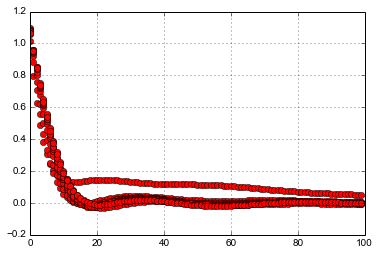

In [107]:
fig= plt.figure()
for i in range (len(cc)):
    plt.plot(range(len(cc[i])),cc[i] ,'ro',label='i')
    #plt.plot(range(len(cc[9])),cc[9] ,'go',label='Image_50')
    #plt.savefig('Run7_3_Image000010_Correlation.png')
plt.grid('on')
    #plt.legend(loc='best')
plt.show()

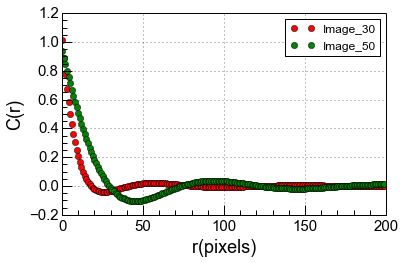

In [78]:
ax=plt.gcf().subplots_adjust(bottom=0.20,left=0.15)

ax=plt.gca()



plt.plot(range(len(cc[2])),cc[2] ,'ro',label='Image_30')
plt.plot(range(len(cc[4])),cc[4] ,'go',label='Image_50')



#ax.set_xscale('log',subsx=[2, 3, 4, 5, 6, 7,8,9])
#ax.set_yscale('log',subsy=[2, 3, 4, 5, 6, 7,8,9])
plt.xlabel('r(pixels) ',fontsize=18)
plt.ylabel('C(r)',fontsize=18)
#plt.xlim(100,1e7)
ax.minorticks_on()
ax.tick_params('both',length=10,width=1,which='major',direction='in')
ax.tick_params('both',length=5,width=1,which='minor',direction='in')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ticklines = ax.get_xticklines()
ticklines.extend( ax.get_yticklines() )
ticklabels = ax.get_xticklabels()
ticklabels.extend( ax.get_yticklabels() )

for label in ticklabels:
      label.set_color('black')
      label.set_fontsize('15')
#plt.suptitle('Crystal density',fontsize=18)
plt.grid('on')
plt.legend(loc='best')
#plt.savefig(path0+'RBlobFitBPPThres03')#BPP=BlobPerPixel
plt.show() 

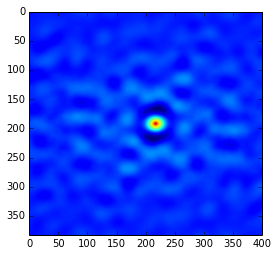

In [93]:
#plt.imshow((np.real(result_windowed[0:400,200:600]))  )
#plt.imsave('test.pdf',(np.real(result_windowed[0:400,200:600])))
fig= plt.figure()
plt.imshow((np.real(result_windowed[0:400,200:600]))  )
plt.savefig('cor.pdf')

(383, 400)


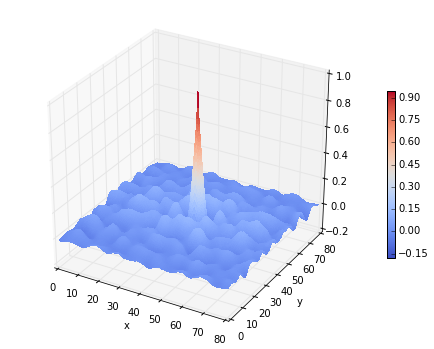

In [18]:
#Making a 3D plot.
print (np.real(result_windowed[0:400,200:600])).shape
my_data=(np.real(result_windowed[0:400,200:600]))
#np.savetxt('my_data',my_data,delimiter=',')

from mpl_toolkits.mplot3d.axes3d import Axes3D
xx,yy=np.linspace(0,80,400),np.linspace(0,80,383)
XX,YY=np.meshgrid(xx,yy)


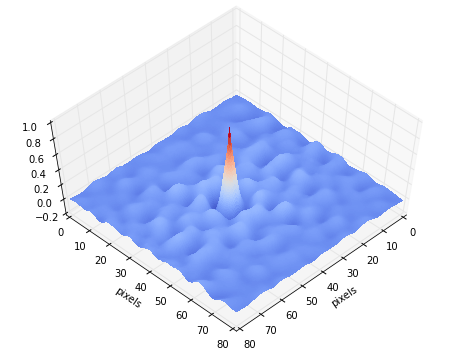

In [26]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1, 1, 1, projection='3d')

p = ax.plot_surface(XX, YY, my_data, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
#cb = fig.colorbar(p, shrink=0.5)
plt.xlabel('pixels')
plt.ylabel('pixels')
#plt.savefig('corre.pdf')
ax.view_init(azim = 45,elev = 60)
plt.savefig('corr3.png')


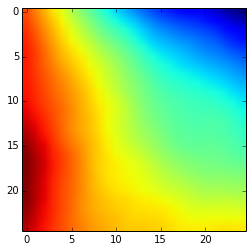

In [22]:
plt.imshow((np.real(result_no_window[115:140,115:140])))

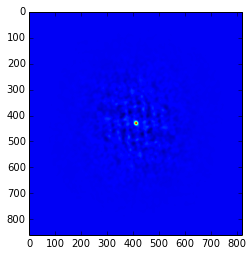

In [54]:
plt.imshow((np.real(result_padded)))

In [ ]:


v_window=Azimuthal_Average((np.real(result_windowed)))

#print find_min_max(result_windowed)
#plt.plot(range(len(v_window)),v_window ,'r')

v_no_window=Azimuthal_Average(np.real(result_no_window))


v_padded=Azimuthal_Average(np.real(result_padded))

v_data=Azimuthal_Average(my_data)

#plt.close()


(383, 832)
383 832
191
(383, 832)
383 832
191
(990, 1439)

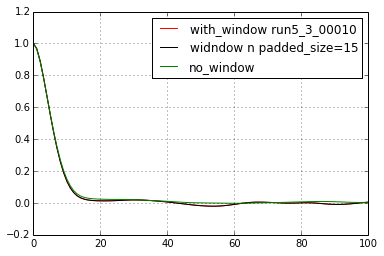

In [57]:
fig= plt.figure()
plt.plot(range(len(v_window)),v_window ,'r-',label='with_window run5_3_00010')
plt.plot(range(len(v_padded)),v_padded,'k-',label='widndow n padded_size=15')
plt.plot(range(len(v_no_window)),v_no_window,'g-',label='no_window')
plt.plot(range(len(v_data)),v_data,'g-',label='truncated')

plt.xlim(0,100)
plt.legend(loc='best')
plt.grid('on')

fig.savefig("Correlation.pdf")

In [58]:
print find_min_max(v_window)
print find_min_max(v_no_window)
print find_min_max(v_padded)

(21, 30)
(61, 86)
(21, 30)


(19, 33)
(21, 30)


/usr/lib/python2.7/dist-packages/numpy/lib/polynomial.py:587: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


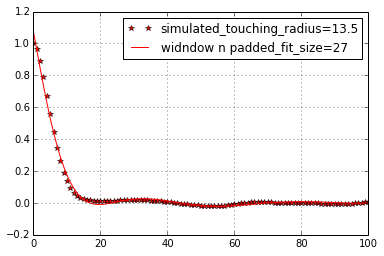

In [59]:
fig= plt.figure()

z=np.poly1d(np.polyfit(range(len(v_padded)), v_padded, 35))
new_x=np.linspace(0,100,100)
#new_x=np.linspace(0,60,100)
#new_x=arange(0,300)
print find_min_max (z(new_x))
print find_min_max(v_padded)
plt.plot(range(len(v_padded)),v_padded, 'r*',label='simulated_touching_radius=13.5')
plt.plot(new_x,z(new_x),'r-',label= 'widndow n padded_fit_size=27')
plt.xlim(0,100)
plt.legend(loc='best')
plt.grid('on')
fig.savefig("Correlation_a.pdf")



In [60]:
print z(new_x)
print find_min_max(v_no_window)
print find_min_max(v_window)

[  1.07317609e+00   9.57559243e-01   8.42451813e-01   7.30952312e-01
   6.25342377e-01   5.27221762e-01   4.37626719e-01   3.57133342e-01
   2.85947368e-01   2.23981789e-01   1.70923526e-01   1.26290331e-01
   8.94789649e-02   5.98056389e-02   3.65395989e-02   1.89306731e-02
   6.23152161e-03  -2.28473781e-03  -7.31091684e-03  -9.49560394e-03
  -9.43597395e-03  -7.67311232e-03  -4.68945311e-03  -9.07972789e-04
   3.30717789e-03   7.64888536e-03   1.18643757e-02   1.57518246e-02
   1.91564642e-02   2.19663482e-02   2.41079170e-02   2.55414785e-02
   2.62567062e-02   2.62682359e-02   2.56114264e-02   2.43383395e-02
   2.25139777e-02   2.02128112e-02   1.75156135e-02   1.45066196e-02
   1.12710093e-02   7.89271743e-03   4.45256369e-03   1.02669137e-03
  -2.31469764e-03  -5.50832908e-03  -8.49858217e-03  -1.12379755e-02
  -1.36874342e-02  -1.58163614e-02  -1.76025347e-02  -1.90318513e-02
  -2.00979434e-02  -2.08016847e-02  -2.11506089e-02  -2.11582588e-02
  -2.08434855e-02  -2.02297136e-02

In [105]:
len(v_no_window)

101

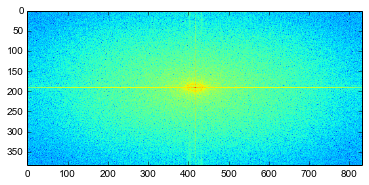

In [323]:
plt.imshow(np.log(np.abs(ft[0])))

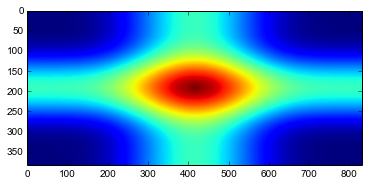

In [290]:
plt.imshow(qa[0])

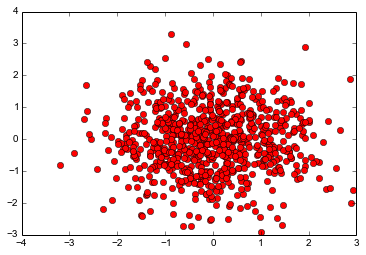

In [33]:
        

plt.plot(np.random.normal(size=800), np.random.normal(size=800), 'ro')



In [27]:
#Modifying this to include points of inflexion. I noticed not all points are a pure minimum and some minimum do occur at the 
#far end of the x axis
def find_min_max(x):
    min_index = -1
    max_index = -1 
    
    grad = []
    for i in range(1, len(x)-1):
        grad.append((x[i+1] - x[i-1])/2)
        
    for i in range(1, len(x)-1):
        if min_index == -1:
            if grad[i-1] > grad[i] and grad[i]< grad[i+1]:
                min_index = i
    else:
        c_max=[] 
        grad_max= (x[i+1]-x[i])/1
        c_max.append(grad_max)  
    if c[i-1] < c[i] and c[i] > c[i+1]:
        max_index = i #Not sure now how to get the index of the first smallest value in the c_max array
        break
    return min_index, max_index

IndentationError: unindent does not match any outer indentation level (<ipython-input-27-2151eacac8ef>, line 22)

In [ ]:
#Original code

def find_min_max(x):
    min_index = -1
    max_index = -1 
    for i in range(1, len(x)-1):
        if min_index == -1:
            if x[i-1] > x[i] and x[i] < x[i+1]:
                min_index = i
    else:
        if x[i-1] < x[i] and x[i] > x[i+1]:
            max_index = i
            break
        return min_index, max_index

In [ ]:
x,y=3,2
my_list=[1,2,3]
my_list=my_list
my_list=[my_list]
my_list2Array=np.array([my_list]*x)
my_list2Array_a=np.array(my_list*x)
print my_list2Array
print my_list2Array_a

print type(my_list2Array)
print type(my_list2Array_a)
print my_list2Array.shape


In [ ]:
print my_list2Array_a.shape